In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

In [2]:
num_epochs = 50
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

In [3]:
#model
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), # optimization
             loss='sparse_categorical_crossentropy', # loss function
             metrics=['accuracy']) # metrics / accuracy

In [5]:
# Data Preprocess

train_paths = sorted(glob('/Users/sengjeawang/Desktop/data/dataset/cifar/train/*.png'))[:1000]
test_paths = sorted(glob('/Users/sengjeawang/Desktop/data/dataset/cifar/test/*.png'))[:1000]

len(train_paths), len(test_paths)

(1000, 1000)

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [7]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)

In [8]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    image = tf.cast(image, tf.float32) / 255.
    
    label = get_label(path)
    return image, label

In [9]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

In [13]:
# Training

steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,

)

/Users/sengjeawang/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
31/31 [==============================] - 3s 75ms/step - loss: 2.3161 - accuracy: 0.1085 - val_loss: 2.2970 - val_accuracy: 0.1179
Epoch 2/50
31/31 [==============================] - 2s 71ms/step - loss: 2.2669 - accuracy: 0.1280 - val_loss: 2.2470 - val_accuracy: 0.1472
Epoch 3/50
31/31 [==============================] - 2s 70ms/step - loss: 2.2023 - accuracy: 0.1748 - val_loss: 2.1151 - val_accuracy: 0.2268
Epoch 4/50
31/31 [==============================] - 2s 70ms/step - loss: 2.1805 - accuracy: 0.1663 - val_loss: 2.1021 - val_accuracy: 0.2218
Epoch 5/50
31/31 [==============================] - 2s 71ms/step - loss: 2.1355 - accuracy: 0.2076 - val_loss: 2.0767 - val_accuracy: 0.2026
Epoch 6/50
31/31 [==============================] - 2s 70ms/step - loss: 2.0373 - accuracy: 0.2417 - val_loss: 1.9898 - val_accuracy: 0.2379
Epoch 7/50
31/31 [==============================] - 2s 70ms/step - loss: 2.0489 - accuracy: 0.2293 - val_loss: 1.9861 - val_accuracy: 0.2601
Epoch 8/50
31

In [14]:
# History 들여다 보기

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 31}

In [16]:
new_model = history.model

In [17]:
history.history['accuracy']

[0.10847107321023941,
 0.12802419066429138,
 0.17478813230991364,
 0.16632232069969177,
 0.20764462649822235,
 0.2417355328798294,
 0.2293388396501541,
 0.2641128897666931,
 0.27582645416259766,
 0.28283897042274475,
 0.2530991733074188,
 0.29233869910240173,
 0.3181818127632141,
 0.3199152648448944,
 0.3578628897666931,
 0.3326271176338196,
 0.3558467626571655,
 0.37706610560417175,
 0.3698347210884094,
 0.38029661774635315,
 0.36466941237449646,
 0.38407257199287415,
 0.39462810754776,
 0.4070248007774353,
 0.3863636255264282,
 0.40909090638160706,
 0.42871901392936707,
 0.4163223206996918,
 0.42458677291870117,
 0.4359503984451294,
 0.4597107470035553,
 0.4638429880142212,
 0.47004133462905884,
 0.47417354583740234,
 0.49793389439582825,
 0.46900826692581177,
 0.48140496015548706,
 0.49193549156188965,
 0.5021186470985413,
 0.5252016186714172,
 0.5351239442825317,
 0.5286017060279846,
 0.538223147392273,
 0.5506198406219482,
 0.5211693644523621,
 0.5762711763381958,
 0.5514112710952

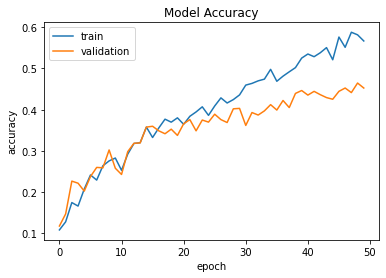

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

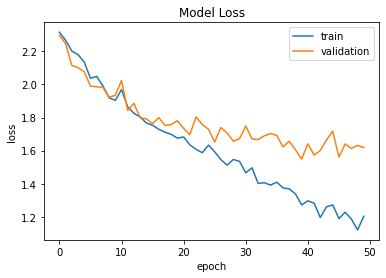

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()